# Imagen a texto

In [1]:
! mkdir ~/.kaggle
! cp drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! kaggle datasets download adityajn105/flickr8k

 99% 1.03G/1.04G [00:03<00:00, 225MB/s]
100% 1.04G/1.04G [00:03<00:00, 282MB/s]


In [3]:
! unzip flickr8k.zip
! rm flickr8k.zip

Archive:  flickr8k.zip
replace Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## 1. Tokenizador

In [4]:
import os, glob, pickle
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import to_categorical

In [5]:
from tensorflow.keras import applications
from tensorflow import keras

In [6]:
from string import punctuation
import numpy as np

In [7]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
class ImageTokenizer:
  def __init__(self, input_shape=(224,224,3), start_token='<START>', end_token='<END>', 
               oov_token='<OOV>', max_length=20, padding='post', 
               truncate='post', num_words=1000):
    self.start_token = start_token
    self.end_token = end_token
    self.oov_token = oov_token
    self.tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    self.padding = padding
    self.truncate = truncate
    self.max_length = max_length
    self.input_shape = input_shape
    vgg16 = applications.VGG16(input_shape=input_shape)
    outputs = vgg16.layers[-2].output
    self.feat_extract = keras.Model(vgg16.inputs, outputs)
  
  def extract_feats(self, img_path):
    img = load_img(img_path, target_size=self.input_shape[:2])
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = applications.vgg16.preprocess_input(img)
    return self.feat_extract.predict(img)[0]

  @staticmethod
  def is_valid(word):
    return len(word)>1 and word.isalpha()
  
  @staticmethod
  def remove_punctuation(word):
    translation = str.maketrans('','',punctuation)
    return word.translate(translation)

  def clean_texts(self, captions):
    cleaned = []
    for caption in captions:
      caption = caption.lower().split(' ')
      caption = map(self.remove_punctuation,caption)
      caption = filter(self.is_valid, caption)
      cleaned.append(self.start_token + ' ' + ' '.join(caption) + ' ' + self.end_token)
    return cleaned
  
  @staticmethod
  def get_max_len(captions):
    max_len = 0
    for caption in captions:
      words = caption.split()
      if len(words)>max_len: max_len = len(words)
    return max_len
  
  def fit(self, imgs_path, captions):
    data = dict()
    last_path = ''
    last_feats = 0
    captions = self.clean_texts(captions)
    self.max_len = self.get_max_len(captions)
    self.tokenizer.fit_on_texts(captions)
    for i in tqdm(range(len(imgs_path))):
      img_path = imgs_path[i]
      caption = captions[i]
      if img_path == last_path:
        feats = last_feats
      else:
        feats = self.extract_feats(img_path)
        last_path = img_path
      data[img_path] = {'features': feats, 'caption':caption}
    
    seqs = self.generate_seqs(data)
    return seqs
  
  def generate_seqs(self, data):
    n_class = len(self.tokenizer.word_index) + 1
    in_feats = []
    in_seqs = []
    out_seqs = []
    for key, value in data.items():
      feats = value['features']
      caption = value['caption']
      seq = self.tokenizer.texts_to_sequences([caption])
      seq = seq[0]
      for i in range(1, len(seq)):
        input_seq = seq[:i]
        input_seq = pad_sequences([input_seq], maxlen=self.max_len,
                                  padding=self.padding, truncating=self.truncate)
        output_seq = seq[i]
        output_seq = to_categorical([output_seq], n_class)[0]
        in_feats.append(feats)
        in_seqs.append(input_seq)
        out_seqs.append(output_seq)
    file_paths = ['in_feats.pickle','input_seqs.pickle','output_seqs.pickle']
    seqs = [in_feats,in_seqs,out_seqs]
    for path, seq in zip(file_paths, seqs):
      with open(path, 'wb') as f:
        pickle.dump(np.array(seq),f)
    
    return seqs
  
  def process_txt(self, captions_txt, path_base='Images/'):
    imgs_path, captions = [], []
    last_path = ''
    with open(captions_txt, 'r') as f:
      f.readline()
      for line in f:
        line = line.strip().split(',')
        img_path = line[0]
        if img_path==last_path:
          continue
        else: last_path = img_path
        caption = ' '.join(line[1:])
        imgs_path.append(path_base + img_path)
        captions.append(caption)
        if len(captions)>1000: break
    seqs = self.fit(imgs_path, captions)
    return seqs

In [9]:
x = [0]
x[:4]

[0]

In [10]:
tokenizer = ImageTokenizer()

In [11]:
seqs = tokenizer.process_txt('captions.txt', path_base='Images/')

100%|██████████| 8091/8091 [08:37<00:00, 15.64it/s]


In [12]:
# Extraemos los datos
in_feats_path = '/content/in_feats.pickle'
input_seqs_path = '/content/input_seqs.pickle'
output_seqs_path = '/content/output_seqs.pickle'

In [13]:
data = []
for i in [in_feats_path,input_seqs_path,output_seqs_path]:
  with open(i,'rb') as f:
    data.append(pickle.load(f))

In [14]:
input_feats, input_seqs, output_seqs = data

In [15]:
input_seqs[:5]

array([[[  3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0]],

       [[  3,  39,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0]],

       [[  3,  39,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0]],

       [[  3,  39,   4,  67,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0]],

       [[  3,  39,   4,  67, 145,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0]]], dtype=int32)

## 2. Red generadora de texto

In [16]:
from tensorflow.keras import layers
from tensorflow import keras

In [30]:
vocabulary_size = 4474 #tokenizer.tokenizer.num_words
max_seq_len = 30
input_shape = (4096,)

In [29]:
tokenizer.tokenizer.num_words

1000

In [28]:
tokenizer.max_len

30

In [31]:
input_img = layers.Input(shape=input_shape)
input_seq = layers.Input(shape=(max_seq_len,))

In [32]:
x = layers.Dropout(0.5)(input_img)
x = layers.Dense(256, activation='relu')(x)

y = layers.Embedding(input_dim=vocabulary_size+1, output_dim=128,)(input_seq)
y = layers.Dropout(0.25)(y)
y = layers.LSTM(units=256)(y)

z = layers.Add()([x,y])
z = layers.Dense(256, activation='relu')(z)
z = layers.Dense(vocabulary_size+1, activation='softmax')(z)

In [33]:
model = keras.Model(inputs=[input_img, input_seq], outputs=z, name='Img2Text')

In [34]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['acc'])

In [35]:
from tensorflow.keras.utils import plot_model

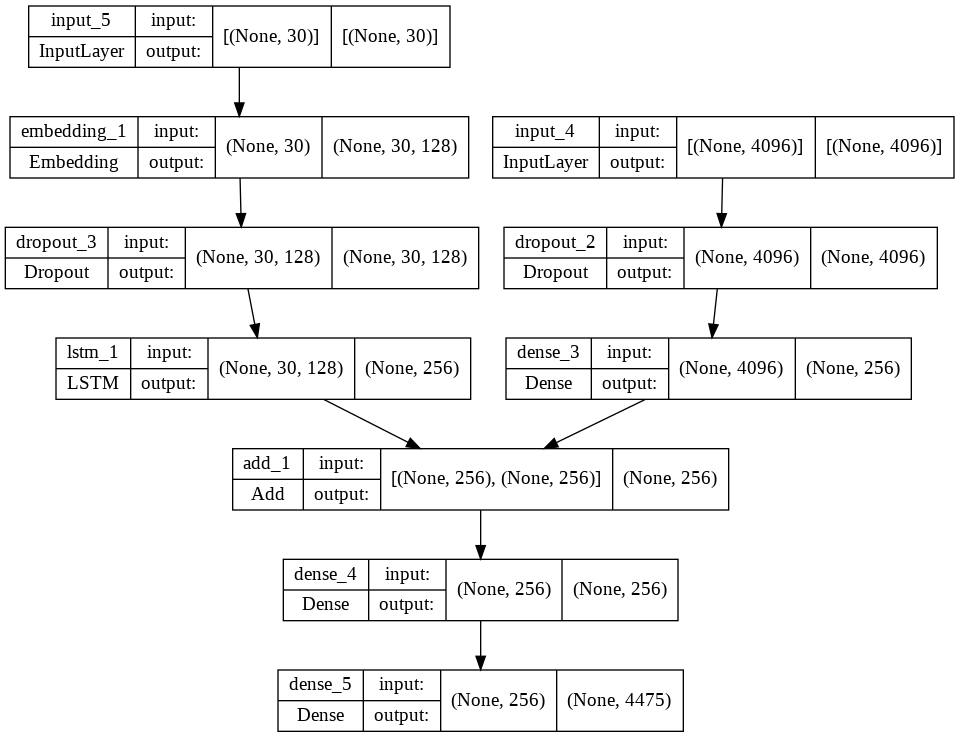

In [36]:
plot_model(model, show_shapes=True)

In [37]:
from tensorflow.keras import callbacks
cb1 = callbacks.EarlyStopping(monitor='acc',patience=5, restore_best_weights=True)

In [ ]:
model.fit([input_feats, input_seqs.squeeze()], output_seqs,epochs=100, batch_size=8, callbacks=[cb1])

Funciones adicionales

In [ ]:
def generate_text(model, tokenizer, img):
  text = '<START>'
  for _ in range(max_seq_len):
    seq = tokenizer.texts_to_sequences([text])[0]
    seq = pad_sequences([seq], maxlen=max_seq_len, padding='post', truncating='post')
    pred = model.predict([img, seq])
    idx = np.argmax(pred)
    word = tokenizer.index_word.get(idx,None)
    if word is None: break
    text += ' ' + word
    if word == '<END>': break
  return text

In [ ]:
img = load_img('/content/Images/1024138940_f1fefbdce1.jpg',target_size=(224,224))
img

In [ ]:
img = np.array(img)
img = applications.vgg16.preprocess_input(img)

In [ ]:
img = np.expand_dims(img, axis=0)

In [ ]:
feats = tokenizer.feat_extract.predict(img)

In [ ]:
generate_text(model, tokenizer.tokenizer, feats)